# Tracking Eigenvalues: The Shift-Invert Power Method

### 1. The Strategy
When studying how a Hamiltonian $H(\lambda)$ behaves as we vary a parameter $\lambda$, we don't need to re-diagonalize the whole matrix at every step. Instead, we use a **"tracking" strategy**:

* **The Anchor:** We start with a full diagonalization for an initial $\lambda_0$ to get our baseline energy $E(\lambda_0)$.
* **The Follow-up:** As we shift $\lambda$ slightly, we assume the new energy will be close to the previous one. We use the previous energy as a "guess" or "shift", denoted $\tilde{E}(\lambda)$.

---

### 2. Why Shift-Invert?
The goal is to force the Power Method to ignore the edges of the spectrum and focus exactly on the energy level we are tracking. We do this by applying the iteration to the inverse operator:

$$[H - \tilde{E}(\lambda)I]^{-1} |\psi_n\rangle = \eta |\psi_{n+1}\rangle$$

In this setup, the closer the actual energy $E$ is to our guess $\tilde{E}$, the more the term $1/(E - \tilde{E})$ blows up, making that specific state dominant. This allows the algorithm to converge very quickly to the state we are following.



---

### 3. Avoiding Matrix Inversion
In practice, explicitly calculating the inverse matrix $[H - \tilde{E}I]^{-1}$ is **extremely long and computationally expensive**, especially for large systems. 

To get around this, we treat each step as a linear system to solve:
$$(H - \tilde{E}I) |w\rangle = |\psi_n\rangle$$

We use the **MINRES** algorithm to find $|w\rangle$. It's a clever iterative solver that finds the solution without ever needing to actually invert the matrix, saving a massive amount of time and memory.

---

### 4. Getting the Results Back
Once the iteration settles, we have successfully "captured" the state. We can then easily recover the physical properties of the system:

* **The Eigenvector:** The converged $|\psi\rangle$ is the new state of your Hamiltonian.
* **The Eigenvalue:** We find the energy $E$ simply by calculating the **Rayleigh quotient**:

$$E = \frac{\langle\psi|H|\psi\rangle}{\langle\psi|\psi\rangle}$$

---

# Implementation

In [23]:
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as dense_linalg
import scipy.sparse as sp
import scipy.sparse.linalg as sp_linalg
from joblib import Parallel, delayed
from scipy import sparse
from threadpoolctl import threadpool_limits
from tqdm.notebook import tqdm


In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 1. Reset pour effacer les vieux réglages (Seaborn, etc.)
mpl.rcParams.update(mpl.rcParamsDefault)

import seaborn as sns
sns.set_context("talk")
sns.set_style("ticks") 

### Conversion $C^{n} \to R^{2n}$

As minres only works with real matrixes, we need to add some function to convert our complex operators (if they are) to real ones.

In [25]:
def to_real_basis(H_complex):
    if sp.issparse(H_complex):
        return sp.bmat([[H_complex.real, -H_complex.imag], [H_complex.imag, H_complex.real]], format="csr")
    else:
        return np.block([[H_complex.real, -H_complex.imag], [H_complex.imag, H_complex.real]])


def vec_to_real(v_complex):
    return np.concatenate((v_complex.real, v_complex.imag))


def vec_to_complex(v_real):
    n = len(v_real) // 2
    return v_real[:n] + 1j * v_real[n:]


def make_real_operator_from_complex(H_complex_op):
    N = H_complex_op.shape[0]

    def matvec_real_wrapper(v_real_2n):
        v_c = vec_to_complex(v_real_2n)
        res_c = H_complex_op @ v_c
        return vec_to_real(res_c)

    return sp_linalg.LinearOperator((2 * N, 2 * N), matvec=matvec_real_wrapper, dtype=np.float64)

### Shift invert implementation

In [26]:
def shift_invert_step_jax(H_op_sigma, v_prev, shift=1e-4, tol=1e-9, N_power=3, tol_exit=1e-7):
    v_prev = v_prev / np.linalg.norm(v_prev)
    E_current = np.vdot(v_prev,H_op_sigma(0)@v_prev)
    v_current = v_prev
    sigma = E_current + shift

    scale_factor = -1.0 / shift

    for _ in range(N_power):
        w, exit_code = sp_linalg.minres(
                H_op_sigma(sigma), v_current, x0=v_current * scale_factor, rtol=tol
            )

        norm_w = np.linalg.norm(w)

        v_new = w / norm_w

        E_new = np.vdot(v_new, H_op_sigma(0) @ v_new).real

        v_current = v_new
        E_current = E_new
        sigma = E_current + shift

        residu = np.linalg.norm(H_op_sigma(E_current)@v_current)

        if residu < tol_exit:
            return E_new, v_new


    return E_current, v_current


In [27]:
def get_branch_jax(H_op_wrapper, E_guess, v_prev, param_list, shift, tol, N_power, tol_exit):
    n_steps = len(param_list)
    energies = np.zeros(n_steps, dtype=np.float64)
    vectors = []

    v_current = np.concatenate((v_prev.real, v_prev.imag))

    E_current = E_guess
    energies[0] = E_current
    vectors.append(v_prev)

    for i in tqdm(range(1, n_steps)):
        phi_val = param_list[i]
        H_op_sigma = lambda s: H_op_wrapper(phi_val, s)

        E_current, v_current = shift_invert_step_jax(
            H_op_sigma, v_prev = v_current, shift=shift, tol=tol, N_power=N_power, tol_exit=tol_exit
        )

        energies[i] = E_current
        vectors.append(vec_to_complex(v_current))

    return energies, np.array(vectors)

### Classical Lanczos implementation

This section is no longer useful as we use the tool implemented by Kyrylo to have the Lanczos value, it was useful for the transmon

In [28]:
def get_values_Lanczos(H_func, n_states, param_list, tol=1e-8, initial_guess=None):
    global residu_lanczos
    H_0 = H_func(param_list[0])
    if not initial_guess:
        E_initial, V_initial = sp_linalg.eigsh(H_0, k=n_states, which="SA")
        idx = E_initial.argsort()
        E_initial = E_initial[idx]
        V_initial = V_initial[:, idx]
    else:
        E_initial, V_initial = initial_guess

    n_steps = len(param_list)
    all_energies = np.zeros((n_steps, n_states), dtype=np.float64)
    all_vectors = []

    all_energies[0, :] = E_initial
    all_vectors.append(V_initial)

    for i in range(1, n_steps):
        H = H_func(param_list[i])

        v0_guess = np.mean(all_vectors[-1], axis=1)

        H = sp_linalg.LinearOperator(H.shape, matvec=IterationCounter(H))

        energies_i, vectors_i = sp_linalg.eigsh(
            H, k=n_states, v0=v0_guess, which="SA", tol=tol, ncv=max(10, 2 * n_states + 1)
        )

        idx = energies_i.argsort()
        energies_i = energies_i[idx]
        vectors_i = vectors_i[:, idx]

        all_energies[i, :] = energies_i
        all_vectors.append(vectors_i)

        norms = np.linalg.norm(H @ vectors_i - vectors_i * energies_i, axis=0)
        residu_lanczos.append(np.mean(norms))

    return all_energies, np.array(all_vectors)


# Same code as before but without taking the previous vector as a guess for the next one
def get_values_Lanczos_no_guess(H_func, n_states, param_list, tol=1e-8):
    H_0 = H_func(param_list[0])
    E_initial, V_initial = sp_linalg.eigsh(H_0, k=n_states, which="SA")

    idx = E_initial.argsort()
    E_initial = E_initial[idx]
    V_initial = V_initial[:, idx]

    n_steps = len(param_list)
    all_energies = np.zeros((n_steps, n_states), dtype=np.float64)
    all_vectors = []

    all_energies[0, :] = E_initial
    all_vectors.append(V_initial)

    for i in range(1, n_steps):
        H = H_func(param_list[i])

        H = sp_linalg.LinearOperator(H.shape, matvec=IterationCounter(H))

        energies_i, vectors_i = sp_linalg.eigsh(H, k=n_states, which="SA", tol=tol, ncv=max(100, 2 * n_states + 1))

        idx = energies_i.argsort()
        energies_i = energies_i[idx]
        vectors_i = vectors_i[:, idx]

        all_energies[i, :] = energies_i
        all_vectors.append(vectors_i)

        norms = np.linalg.norm(H @ vectors_i - vectors_i * energies_i, axis=0)
        residu_lanczos.append(np.mean(norms))

    return all_energies, np.array(all_vectors)


class IterationCounter:
    def __init__(self, mat):
        self.mat = mat
        self.count = 0

    def __call__(self, x):
        self.count += 1
        return self.mat @ x


class IterationCounter:
    def __init__(self, mat):
        self.mat = mat
        self.count = 0

    def __call__(self, x):
        self.count += 1
        return self.mat @ x


# Kite application

In [30]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath('')) # Force Python à regarder dans le dossier courant

from common_kite import kite_spectrum_jax_vec as vkite

import jax

jax.config.update("jax_enable_x64", True) 

import jax.numpy as jnp
from functools import partial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We have to define a scipy linealg operator from the kite to give it to our shift invert

In [31]:
@partial(jax.jit, static_argnames=("dims", "n_g", "phiext_val"))
def global_core_matvec(v_jax_2d, phiext_val, sigma, n_g, ops, dims):
    Hv = vkite.apply_qr_hamitonian_to_vec(ops, dims, v_jax_2d, n_g, phiext=phiext_val)
    return Hv - sigma * v_jax_2d



def get_shifted_kite_operator_real(phiext_val, ops, dims, n_g, sigma):
    """
    Build a real-valued SciPy LinearOperator representing (H - sigma * I),
    where H is applied through a JAX-jitted matrix-vector product.

    The operator maps a real vector of size 2N to 2N, corresponding to the
    real and imaginary parts of a complex vector in C^N. This allows the use
    of real-valued Krylov solvers such as MINRES while keeping the Hamiltonian
    application fully in JAX.

    Parameters
    ----------
    phiext_val : float
        External flux parameter entering the Hamiltonian.
    ops : object
        Precomputed operator structures used to apply the Hamiltonian.
    dims : tuple
        Hilbert space dimensions.
    n_g : float
        Offset charge parameter.
    sigma : float
        Spectral shift defining the operator (H - sigma I).
    """

    dims_tuple = tuple(dims)
    complex_dim = np.prod(dims)
    real_dim = 2 * complex_dim

    def matvec_real(v_real_numpy):
        v_complex = v_real_numpy[:complex_dim] + 1j * v_real_numpy[complex_dim:]
        v_jax_2d = jnp.array(v_complex)[:, None]
        
        res_2d = global_core_matvec(v_jax_2d, phiext_val, sigma, n_g, ops, dims_tuple)
        
        res_complex = np.array(res_2d.ravel(), dtype=np.complex128)
        return np.concatenate((res_complex.real, res_complex.imag))

    return sp_linalg.LinearOperator(
        shape=(real_dim, real_dim),
        matvec=matvec_real,
        dtype=np.float64
    )


# Functions for benchmark and plots

In [32]:
def compute_variance_trajectory(Vs, flux_vals, ops, dims):
    variances = []
    for v, phi in zip(Vs, flux_vals):
        v = np.array(v).reshape(-1, 1)
        norm = np.linalg.norm(v)
        if norm > 1e-12: 
            v = v / norm
        
        hv = vkite.apply_qr_hamitonian_to_vec(ops, dims, v, n_g=0.0, phiext=phi)
        
        E_local = np.vdot(v, hv).real
        resid = hv - E_local * v
        var = np.linalg.norm(resid)**2
        variances.append(var)
        
    return np.array(variances)


# Plots
for the report presentation, benchmarks are after

In [ ]:
%matplotlib qt

flux_bench = np.linspace(1.565, 1.605, 20)

parameters = vkite.ParamType(
    ECs_GHz=0.072472,
    EL_GHz=1.269,
    ECJ_GHz=4.9895,
    EJ_GHz=17.501,
    eps=0.05702,
    ECc_GHz=0.003989,
    f_r_GHz=4.337,
)


base_dims = np.array([19, 32, 32, 5])
raw_dims = (base_dims / 1.6).astype(int)
dims = np.where(raw_dims % 2 == 0, raw_dims + 1, raw_dims)
dims = np.maximum(dims, 3)
dims = tuple(dims)
print(f'dimension Hilbert space = {dims}')

dim_kept = 8

# Storage arrays for the REFERENCE (Ground Truth)
ref_evals_bench = np.zeros((len(flux_bench), dim_kept))
ref_evecs_bench = np.zeros((len(flux_bench), np.prod(dims), dim_kept), dtype=complex)

print(f"1. Computing QR Reference on the crossing zone ({len(flux_bench)} flux points)...")

for i, flux in enumerate(tqdm(flux_bench)):
    ev, ek, _ = vkite.get_qr_esys_with_jac(
        dims=dims, dim_kept=dim_kept, n_g=0.0, phiext=float(flux),
        **parameters, output_jac_params=tuple(),
    )
    ref_evals_bench[i] = ev
    ref_evecs_bench[i] = ek

import matplotlib.pyplot as plt
import numpy as np

# On vérifie combien de niveaux sont disponibles dans la simulation
n_available = ref_evals_bench.shape[1]
n_plot = n_available  # On trace 5 ou le max dispo


plt.figure(figsize=(10, 6))

# Palette de couleurs
colors = plt.cm.viridis(np.linspace(0, 0.85, n_plot))

for k in range(n_plot):
    plt.plot(flux_bench, ref_evals_bench[:, k], 
             marker='o', linestyle='-',
             label=f'Level {k}', color=colors[k])

# Labels en anglais avec LaTeX pour le phi
plt.xlabel(r'$\varphi_{ext}$ (External Flux)', fontsize=13)
plt.ylabel('Energy (Eigenvalues)', fontsize=13)
plt.title(f'Kite Spectrum: First {n_plot} Levels vs Flux', fontsize=15)

plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



dimension Hilbert space = (np.int64(11), np.int64(21), np.int64(21), np.int64(3))
1. Computing QR Reference on the crossing zone (20 flux points)...


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [01:04<00:27,  4.58s/it]


KeyboardInterrupt: 

### 4 levels

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# --- STYLE PRO & AÉRÉ (inchangé) ---
plt.rcParams.update({
    'font.size': 20,
    'font.weight': 'bold',
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'lines.linewidth': 5,
    'lines.markersize': 12,
    'axes.linewidth': 3,
})

# Données
n_available = ref_evals_bench.shape[1]
# On s'assure d'en afficher assez pour avoir le level 4
n_plot = min(n_available, 6) if n_available > 4 else n_available

# Figure large (14x10)
fig, ax = plt.subplots(figsize=(14, 10), layout='constrained')

# Palette de couleurs de base (viridis)
colors = plt.cm.turbo(np.linspace(0, 0.9, n_plot))

# Boucle de tracé
for k in range(n_plot):
    # --- MODIF ICI : Condition pour le Level 4 ---
    if k == 3:
        current_color = 'purple'   # Rouge vif
        z_ord = 10              # On le met au premier plan (au-dessus des autres)
    else:
        current_color = colors[k] # Couleur standard viridis
        z_ord = 1               # Plan standard

    ax.plot(flux_bench, ref_evals_bench[:, k],
            marker='o', linestyle='-',
            label=f'Level {k}',
            color=current_color,
            alpha=0.9,
            zorder=z_ord) # Utilisation du zorder

# --- AXES TRÈS GROS ---
ax.set_xlabel(r'$\varphi_{ext}$ (External Flux)', fontsize=32, fontweight='bold', labelpad=20)
ax.set_ylabel('Energy (GHz)', fontsize=32, fontweight='bold', labelpad=20)

# Titre
ax.set_title(f'Kite Spectrum Overview', fontsize=34, fontweight='bold', pad=30)

# --- FINITIONS ---
ax.grid(True, linestyle='--', alpha=0.3, linewidth=2)

# Style "Aéré" (Despine)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Légende
ax.legend(fontsize=20, loc='best', frameon=True, framealpha=0.9, edgecolor='white')

plt.show()

### Plot illustrating variance

In [28]:
import numpy as np
import time
from tqdm import tqdm

idx_lower = 6
idx_upper = 7
iterations = []

base_dims = np.array([19, 32, 32, 5])
raw_dims = (base_dims / 1.6).astype(int)
dims = np.where(raw_dims % 2 == 0, raw_dims + 1, raw_dims)
dims = np.maximum(dims, 3)
dims = tuple(dims)

parameters = vkite.ParamType(
    ECs_GHz=0.072472,
    EL_GHz=1.269,
    ECJ_GHz=4.9895,
    EJ_GHz=17.501,
    eps=0.05702,
    ECc_GHz=0.003989,
    f_r_GHz=4.337,
)

ops = vkite.build_static_operators(dims=dims, **parameters)

def my_wrapper(phi, sigma):
    return get_shifted_kite_operator_real(phiext_val=phi, ops=ops, dims=dims, n_g=0.0, sigma=sigma)

def compute_variance_trajectory(Vs, flux_vals, ops, dims):
    variances = []
    for v, phi in zip(Vs, flux_vals):
        v = np.array(v).reshape(-1, 1)
        norm = np.linalg.norm(v)
        if norm > 1e-12: 
            v = v / norm
        
        hv = vkite.apply_qr_hamitonian_to_vec(ops, dims, v, n_g=0.0, phiext=phi)
        
        E_local = np.vdot(v, hv).real
        resid = hv - E_local * v
        var = np.linalg.norm(resid)**2
        variances.append(var)
        
    return np.array(variances)

shift_values = np.logspace(-1, -1, 1) 

metrics = {
    "shift": shift_values,
    "total_time": [],
    "max_validity_error": [], 
    "min_safety_gap": []
}

history_lo = []
history_var_lo = []

print(f"\n2. Launching Shift Benchmark ({len(shift_values)} values)...")

for s in tqdm(shift_values):
    t0_cycle = time.time()
    
    E_init_lo = ref_evals_bench[0, idx_lower]
    v_init_lo = ref_evecs_bench[0, :, idx_lower]
    
    Es_lo, Vs_lo = get_branch_jax(
        my_wrapper, E_init_lo, v_init_lo, flux_bench, 
        shift=s, tol=1e-10, tol_exit=1e-10, N_power=4
    )
    
    history_lo.append(Es_lo)
    
    var_traj_lo = compute_variance_trajectory(Vs_lo, flux_bench, ops, dims)
    history_var_lo.append(var_traj_lo)
    
    metrics["total_time"].append(time.time() - t0_cycle)
    
    dist_lo_ref7 = np.abs(np.array(Es_lo) - ref_evals_bench[:, idx_upper])
    dist_lo_ref6 = np.abs(np.array(Es_lo) - ref_evals_bench[:, idx_lower])
    err_lo = np.minimum(dist_lo_ref7, dist_lo_ref6)
    
    metrics["max_validity_error"].append(np.max(err_lo))


2. Launching Shift Benchmark (1 values)...


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:23<00:00, 83.14s/it]


In [ ]:
import matplotlib.pyplot as plt

# --- CONFIGURATION PPT (LISIBILITÉ MAXIMALE) ---
base_size = 24
plt.rcParams.update({
    'font.size': base_size,
    'font.weight': 'bold',
    'axes.labelsize': base_size + 4,
    'axes.titlesize': base_size + 6,
    'xtick.labelsize': base_size + 2,
    'ytick.labelsize': base_size + 2,
    'legend.fontsize': 18,
    'lines.linewidth': 5,
    'lines.markersize': 12,
})

# ==========================================
# FIGURE 1: COMPUTATIONAL COST (LE GROS PLOT - GAUCHE)
# ==========================================
fig1, ax1 = plt.subplots(figsize=(10, 8), layout='constrained')

# Trace Lanczos (Reference)
ax1.loglog(results["dim_kept"], results["time_ref_baseline"], 'k--', label='Lanczos', linewidth=5, alpha=0.7)

# Trace SI
for i, step in enumerate(flux_steps):
    ax1.loglog(results["dim_kept"], results[step]["time_si"], 'o-', color=colors[i], label=f'SI step={step:.0e}')

ax1.set_xlabel("Target Eigenstate Index")
ax1.set_ylabel("Computation Time (s)")
ax1.grid(True, which="both", alpha=0.4, linewidth=2)
ax1.legend(loc='best')
plt.show()

# ==========================================
# FIGURE 2 & 3 COMBINÉES: QUALITY & CONSISTENCY (DROITE)
# ==========================================
# sharex=True permet de n'avoir l'axe X qu'en bas
# figsize=(9, 10) pour avoir la hauteur de deux plots empilés
fig_comb, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(9, 10), sharex=True, layout='constrained')

# --- PLOT DU HAUT : VARIANCE ---
# Trace Lanczos
ax_top.loglog(results["dim_kept"], results["variance_ref_baseline"], 
           color='black', linestyle='--', linewidth=5, alpha=0.8, 
           label='Lanczos')

# Trace SI
for i, step in enumerate(flux_steps):
    ax_top.loglog(results["dim_kept"], results[step]["variance_si"], 
               marker='s', linestyle='-', color=colors[i], 
               label=f'SI Step={step:.0e}')

ax_top.set_ylabel(r"Variance (GHz$^2$)")
ax_top.grid(True, which="both", alpha=0.4, linewidth=2)
ax_top.legend(loc='best', fontsize=16, ncol=2) 


# --- PLOT DU BAS : OVERLAP ---
for i, step in enumerate(flux_steps):
    c = colors[i]
    # 1. Lanczos -> Pas de légende
    ax_bot.semilogx(results["dim_kept"], results

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# --- MODE XXL (Style Slide) ---
base_size = 32
params = {
    'font.size': base_size,
    'font.weight': 'bold',
    'axes.labelsize': base_size + 4,
    'axes.titlesize': base_size + 6,
    'xtick.labelsize': base_size,
    'ytick.labelsize': base_size,
    'legend.fontsize': 24,
    'lines.linewidth': 6,
    'lines.markersize': 12,
    'axes.linewidth': 4,
    'xtick.major.width': 4,
    'ytick.major.width': 4,
    'xtick.major.size': 12,
    'ytick.major.size': 12,
}
plt.rcParams.update(params)

# --- PLOT FORMAT PANORAMIQUE (16 x 6) ---
fig, ax = plt.subplots(figsize=(16, 6), layout='constrained')

# 1. Branche du BAS (Celle que tu as suivie) -> PLEIN + Marqueurs
ax.plot(flux_bench, ref_evals_bench[:, idx_lower], 
        color='black', 
        linestyle='-',       # Trait plein = Cible
        marker='o',          # Ronds
        markersize=12, 
        linewidth=6, 
        alpha=1.0, 
        label='Lower Branch (Target)')

# 2. Branche du HAUT (Contexte) -> POINTILLÉS + Marqueurs
ax.plot(flux_bench, ref_evals_bench[:, idx_upper], 
        color='black', 
        linestyle='--',      # Pointillés = Autre branche
        marker='o',
        markersize=12, 
        linewidth=6, 
        alpha=0.6,           # Un peu plus transparent
        label='Upper Branch (Context)')

# --- AXES ET LABELS ---
ax.set_title('Benchmark Reference Spectrum', fontweight='bold', pad=25)
ax.set_xlabel(r'External Flux $\varphi_{ext}$', fontweight='bold', labelpad=10)
ax.set_ylabel('Energy (GHz)', fontweight='bold', labelpad=10)
ax.grid(True, which='major', alpha=0.5, linewidth=2)

# --- GESTION DES BORDURES (Style Pro) ---
f_min = flux_bench[0]
f_max = flux_bench[-1]

# On colle les bords
ax.set_xlim(f_min, f_max)

# 5 ticks exacts pour ne pas surcharger la largeur
ax.set_xticks(np.linspace(f_min, f_max, 5))

# --- LÉGENDE ---
legend = ax.legend(loc='lower center', 
                   ncol=2, 
                   frameon=True, 
                   framealpha=0.95, 
                   edgecolor='black')
legend.get_frame().set_linewidth(3)

plt.show()

NameError: name 'flux_bench' is not defined

### Plot explaining Benchmark

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# --- MODE XXL (Style Slide Panoramique) ---
base_size = 32
params = {
    'font.size': base_size,
    'font.weight': 'bold',
    'axes.labelsize': base_size + 4,
    'axes.titlesize': base_size + 6,
    'xtick.labelsize': base_size,
    'ytick.labelsize': base_size,
    'lines.linewidth': 6,
    'lines.markersize': 14,    # Gros marqueurs
    'axes.linewidth': 4,
    'xtick.major.width': 4,
    'ytick.major.width': 4,
    'xtick.major.size': 12,
    'ytick.major.size': 12,
}
plt.rcParams.update(params)

# --- PLOT FORMAT BANDEAU (24 x 5) ---
# dpi=100 aide à fixer la taille en pixels si figsize est capricieux
fig, ax = plt.subplots(figsize=(30, 5), layout='constrained', dpi=50)

# 1. Branche du BAS (Cible) -> Trait PLEIN + Marqueurs
ax.plot(flux_bench, ref_evals_bench[:, idx_lower], 
        color='black', 
        linestyle='-',       
        marker='o',          
        linewidth=6, 
        alpha=1.0)

# 2. Branche du HAUT (Contexte) -> POINTILLÉS + Marqueurs
ax.plot(flux_bench, ref_evals_bench[:, idx_upper], 
        color='black', 
        linestyle='--',      
        marker='o',
        linewidth=6, 
        alpha=0.5)

# --- AXES ET LABELS ---
ax.set_xlabel(r'External Flux $\varphi_{ext}$', fontweight='bold', labelpad=10)
ax.set_ylabel('Energy (GHz)', fontweight='bold', labelpad=10)
ax.grid(True, which='major', alpha=0.5, linewidth=2)

# --- GESTION DES BORDURES ---
f_min = flux_bench[0]
f_max = flux_bench[-1]

# On colle les bords
ax.set_xlim(f_min, f_max)

# 5 ticks exacts pour ne pas surcharger la largeur
ax.set_xticks(np.linspace(f_min, f_max, 5))

plt.show()

### overlaping plot

In [36]:


flux_bench = np.linspace(1.565, 1.605, 5)

parameters = vkite.ParamType(
    ECs_GHz=0.072472,
    EL_GHz=1.269,
    ECJ_GHz=4.9895,
    EJ_GHz=17.501,
    eps=0.05702,
    ECc_GHz=0.003989,
    f_r_GHz=4.337,
)

base_dims = np.array([19, 32, 32, 5])
raw_dims = (base_dims / 1.6).astype(int)
dims = np.where(raw_dims % 2 == 0, raw_dims + 1, raw_dims)
dims = np.maximum(dims, 3)
dims = tuple(dims)
print(f'dimension Hilbert space = {dims}')

dim_kept = 8
ref_evals_bench = np.zeros((len(flux_bench), dim_kept))
ref_evecs_bench = np.zeros((len(flux_bench), np.prod(dims), dim_kept), dtype=complex)

print(f"Computing Reference ({len(flux_bench)} points)...")

for i, flux in enumerate(tqdm(flux_bench)):
    ev, ek, _ = vkite.get_qr_esys_with_jac(
        dims=dims, dim_kept=dim_kept, n_g=0.0, phiext=float(flux),
        **parameters, output_jac_params=tuple(),
    )
    ref_evals_bench[i] = ev
    ref_evecs_bench[i] = ek

dimension Hilbert space = (np.int64(11), np.int64(21), np.int64(21), np.int64(3))
Computing Reference (5 points)...


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:24<00:00,  4.81s/it]


In [38]:
import time

ops = vkite.build_static_operators(dims=dims, **parameters)

def my_wrapper(phi, sigma):
    return get_shifted_kite_operator_real(phi, ops, dims, n_g=0.0, sigma=sigma)

bad_shift = 0.9
E_init = ref_evals_bench[0, 0]
v_init = ref_evecs_bench[0, :, 0]

print(f"Launching 'Bad Shift' Tracking (Shift = {bad_shift} GHz)...")

Es_bad, Vs_bad = get_branch_jax(
    my_wrapper, 
    E_init, 
    v_init, 
    flux_bench, 
    shift=bad_shift, 
    tol=1e-10, 
    tol_exit=1e-10, 
    N_power=10
)

overlaps = [1.0]
for i in range(1, len(Vs_bad)):
    v_prev = Vs_bad[i-1]
    v_curr = Vs_bad[i]
    ov = np.abs(np.vdot(v_prev, v_curr))
    overlaps.append(ov)

overlaps = np.array(overlaps)
print("Calcul terminé.")

Launching 'Bad Shift' Tracking (Shift = 0.9 GHz)...


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:31<00:00,  7.77s/it]

Calcul terminé.


In [47]:
import matplotlib.pyplot as plt
import numpy as np

# --- MODE XXL (COHÉRENT AVEC LE PREMIER PLOT) ---
base_size = 32
params = {
    'font.size': base_size,
    'font.weight': 'bold',
    'axes.labelsize': base_size + 4,
    'axes.titlesize': base_size + 6,
    'xtick.labelsize': base_size,
    'ytick.labelsize': base_size,
    'legend.fontsize': 25,      # <--- TAILLE 25 COMME DEMANDÉ
    'lines.linewidth': 6,
    'lines.markersize': 14,     # Un peu plus gros pour bien voir
    'axes.linewidth': 4,
    'xtick.major.width': 4,
    'ytick.major.width': 4,
    'xtick.major.size': 12,
    'ytick.major.size': 12,
}
plt.rcParams.update(params)

fig, ax = plt.subplots(figsize=(16, 11), layout='constrained')

# 1. Références (En GRIS clair pour le fond)
# On limite à quelques niveaux pour pas surcharger
n_levels_to_show = min(5, ref_evals_bench.shape[1])
for k in range(n_levels_to_show):
    label = "Reference" if k == 0 else ""
    ax.plot(flux_bench, ref_evals_bench[:, k], 
            color='gray', alpha=0.3, linewidth=12, label=label)

# 2. Axe Overlap (Droite) - On le crée maintenant
ax_ov = ax.twinx()

# 3. Tracé des courbes principales

# --- ENERGIE (GAUCHE) -> NOIR ---
ax.plot(flux_bench, Es_bad, 
        color='black', 
        marker='o', markersize=10, linestyle='-', alpha=1.0,
        label='Shift Invert')

# --- OVERLAP (DROITE) -> BLEU ---
ax_ov.plot(flux_bench, overlaps, 
           color='#1f77b4', # Bleu standard matplotlib
           marker='d', markersize=12, linestyle='--', linewidth=6, alpha=0.9,
           label=r'Overlap $|\langle \psi_i | \psi_{i+1} \rangle|$')

# 4. Axes et Labels
ax.set_title('State Jump', fontweight='bold', pad=25)
ax.set_xlabel(r'External Flux $\varphi_{ext}$', fontweight='bold', labelpad=10)

# AXE GAUCHE (ENERGIE - NOIR)
ax.set_ylabel('Energy (GHz)', fontweight='bold', labelpad=10, color='black')
ax.tick_params(axis='y', labelcolor='black', width=4, length=12)

# AXE DROITE (OVERLAP - BLEU)
ax_ov.set_ylabel('Overlap (Linear)', fontweight='bold', labelpad=50, rotation=270, color='#1f77b4')
ax_ov.tick_params(axis='y', labelcolor='#1f77b4', width=4, length=12)
ax_ov.spines['right'].set_color('#1f77b4')
ax_ov.spines['right'].set_linewidth(4)
ax_ov.spines['left'].set_color('black') # L'axe de gauche est noir
ax_ov.spines['left'].set_linewidth(4)
ax_ov.set_ylim(-0.05, 1.1) 

# 5. Gestion des frontières (Style "Pro" identique à l'autre plot)
f_min = flux_bench[0]
f_max = flux_bench[-1]

ax.set_xlim(f_min, f_max)
ax.set_xticks(np.linspace(f_min, f_max, 5)) # 5 ticks exactement, bornes incluses

ax.grid(True, which='major', alpha=0.5, linewidth=2)

# 6. Légende fusionnée
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_ov.get_legend_handles_labels()

# On filtre "Reference" pour ne pas l'avoir 5 fois, mais le handle gère ça souvent seul
# Ordre : Reference, Shift Invert, Overlap
legend = ax.legend(lines1 + lines2, labels1 + labels2, 
                   loc='upper center', # Ou 'center right' selon tes données
                   ncol=1, frameon=True, framealpha=0.95, 
                   edgecolor='black')
legend.get_frame().set_linewidth(3)

plt.show()

### Plot Krylov 

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
# figsize=(8, 10) -> Plus haut que large pour "compresser" horizontalement
# linewidth=2 -> Traits fins pour bien voir les détails
plt.rcParams.update({
    'lines.linewidth': 2,       
    'figure.figsize': (8, 10)   
})

# --- GÉNÉRATION DES SIGNAUX (Haute résolution) ---
t = np.linspace(0, 4*np.pi, 2000) # Encore plus de points pour la finesse

# 1. Haute Fréquence
freq_high = 20.0
amp_high = 0.8
y_high = amp_high * np.sin(freq_high * t)

# 2. Basse Fréquence
freq_low = 1.0
amp_low = 1.0 
y_low = amp_low * np.sin(freq_low * t)

# 3. Le Mix
y_total = y_high + y_low

# --- PLOT CLEAN ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

# Ajustement de l'espace
plt.subplots_adjust(hspace=0.1) 

# ÉTAPE 1 : Le Mélange
ax1.plot(t, y_total, color='black')
ax1.set_axis_off()

# ÉTAPE 2 : La Haute Fréquence seule
ax2.plot(t, y_high, color='#D62728') # Rouge
ax2.set_axis_off()

# ÉTAPE 3 : La Basse Fréquence seule
ax3.plot(t, y_low, color='#1F77B4') # Bleu
ax3.set_axis_off()

plt.show()

# Benchmark

Used parameters on the kite 

In [14]:
parameters = vkite.ParamType(
    ECs_GHz=0.072472,
    EL_GHz=1.269,
    ECJ_GHz=4.9895,
    EJ_GHz=17.501,
    eps=0.05702,
    ECc_GHz=0.003989,
    f_r_GHz=4.337,
)


dims = vkite.DEFAULT_DIMS
dims = tuple((np.array(dims) // 1.6).astype(int))
print(f'dimension Hilbert space = {dims}')

ops = vkite.build_static_operators(dims = dims, **parameters)

def my_wrapper(phi, sigma):
    return get_shifted_kite_operator_real(phiext_val=phi, ops=ops, dims=dims, n_g=0.0, sigma=sigma)

dimension Hilbert space = (np.int64(11), np.int64(19), np.int64(19), np.int64(3))


### Benchmark shift value

In [71]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

# --- 1. SETUP: HIGH-RESOLUTION REFERENCE ---
# Zooming in on the critical crossing area
flux_bench = np.linspace(1.565, 1.605, 20)

dim_kept = 8
idx_upper = dim_kept - 1 # Branch 7
idx_lower = dim_kept - 2 # Branch 6

# Storage arrays for the REFERENCE (Ground Truth)
ref_evals_bench = np.zeros((len(flux_bench), dim_kept))
ref_evecs_bench = np.zeros((len(flux_bench), np.prod(dims), dim_kept), dtype=complex)

print(f"1. Computing QR Reference on the crossing zone ({len(flux_bench)} flux points)...")

t_0 = time.time()
for i, flux in enumerate(tqdm(flux_bench)):
    ev, ek, _ = vkite.get_qr_esys_with_jac(
        dims=dims, dim_kept=dim_kept, n_g=0.0, phiext=float(flux),
        **parameters, output_jac_params=tuple(),
    )
    ref_evals_bench[i] = ev
    ref_evecs_bench[i] = ek
t_1 = time.time()
lanczos_time = (t_1 - t_0)/len(flux_bench)

print("   -> Reference computed. Ready for benchmark.")

print(lanczos_time)

1. Computing QR Reference on the crossing zone (20 flux points)...


100%|██████████| 20/20 [01:45<00:00,  5.28s/it]

   -> Reference computed. Ready for benchmark.
5.283517479896545


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import time
from tqdm import tqdm

iterations = []

# --- PARAMETERS ---
shift_values = np.concatenate((np.logspace(-14, -1, 14),np.array([0.5])),axis=0)

metrics = {
    "shift": shift_values,
    "total_time": [],
    "max_validity_error": [],
    "mean_overlap_lo": [],
    "mean_overlap_up": [],
    "min_overlap_up": [],
    "max_variance":[]
}

history_up = [] 
history_lo = []

print(f"\n2. Launching Shift Benchmark ({len(shift_values)} values)...")

for s in tqdm(shift_values):
    t0_cycle = time.time()
    
    # === A. UPPER TRACKING ===
    E_init_up = ref_evals_bench[0, idx_upper]
    v_init_up = ref_evecs_bench[0, :, idx_upper]
    
    t0_cycle = time.time()
    Es_up, Vs_up = get_branch_jax(
        my_wrapper, E_init_up, v_init_up, flux_bench, 
        shift=s, tol=1e-10, tol_exit=1e-10, N_power=10
    )
    t1_cycle = time.time()
    history_up.append(Es_up)
    
    # Calculate overlaps for Upper branch
    ov_up = [np.abs(np.vdot(Vs_up[k], Vs_up[k+1])) for k in range(len(Vs_up)-1)]
    metrics["mean_overlap_up"].append(np.mean(ov_up))
    metrics["min_overlap_up"].append(np.min(ov_up))
    
    # === C. METRICS ===
    metrics["total_time"].append((t1_cycle - t0_cycle)/len(flux_bench))
    
    dist_up_ref7 = np.abs(np.array(Es_up) - ref_evals_bench[:, idx_upper])
    dist_up_ref6 = np.abs(np.array(Es_up) - ref_evals_bench[:, idx_lower])
    err_up = np.max(np.minimum(dist_up_ref7, dist_up_ref6))
    variance = compute_variance_trajectory(Vs_up, flux_bench, ops, dims)

    
    metrics["max_validity_error"].append(err_up)
    metrics["max_variance"].append(np.max(variance))

# ==========================================
# FIGURE 1: QUANTITATIVE METRICS (DASHBOARD)
# ==========================================



2. Launching Shift Benchmark (15 values)...


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [26:49<00:00, 107.31s/it]


In [74]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

%matplotlib qt

# --- CONFIGURATION XXL "SLIDE VISIBILITY" ---
base_size = 24  # Augmenté de 22 à 24
plt.rcParams.update({
    'font.size': base_size,            # Taille de base augmentée
    'axes.labelsize': base_size + 6,   # Noms des axes (Labels) -> TRÈS GROS
    'axes.titlesize': base_size + 8,   # Titres -> ÉNORMES
    'xtick.labelsize': base_size + 4,  # Nombres sur l'axe X -> GROS (C'était le problème)
    'ytick.labelsize': base_size + 4,  # Nombres sur l'axe Y -> GROS
    'legend.fontsize': base_size,      # Légende lisible
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'lines.linewidth': 5,              # Lignes encore plus épaisses pour matcher le texte
    'figure.figsize': (14, 10)
})

# Récupération des données (Simulation)
x_shift = metrics["shift"]
y_error = metrics["max_variance"]
y_overlap = metrics["min_overlap_up"]
y_time = metrics["total_time"]

# ==========================================
# FIGURE 1: ACCURACY & CORRECTNESS (Dual Axis)
# ==========================================
fig1, ax1 = plt.subplots(layout='constrained') # 'constrained' aide à ne pas couper les gros textes

# --- Axe Gauche : VARIANCE ---
color_err = '#D62728' # Rouge plus "pro"
ax1.set_xlabel('Shift Parameter (log)')
ax1.set_ylabel(r'Max Variance $[GHz]^2$', color=color_err) 
ln1 = ax1.loglog(x_shift, y_error, color=color_err, marker='x', markersize=14, linestyle='--', label='Variance')
ax1.tick_params(axis='y', labelcolor=color_err, width=4, length=12) # Ticks plus épais et longs
ax1.grid(True, which="both", alpha=0.3)

# --- Axe Droit : OVERLAP ---
ax2 = ax1.twinx()
color_ov = '#9467BD' # Violet plus "pro"
ax2.set_ylabel('Min Overlap', color=color_ov)
ln2 = ax2.semilogx(x_shift, y_overlap, color=color_ov, marker='^', markersize=12, alpha=0.8, label='Overlap')
ax2.tick_params(axis='y', labelcolor=color_ov, width=4, length=12)

# Réglage dynamique overlap
ov_min = np.min(y_overlap)
ov_max = np.max(y_overlap)
margin = (ov_max - ov_min) * 0.1 if ov_max != ov_min else 0.01
ax2.set_ylim(ov_min - margin, ov_max + margin)

plt.title('Accuracy and Correctness')

# Légende combinée
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center left')

plt.show()

# ==========================================
# FIGURE 2: COMPUTATIONAL PERFORMANCE
# ==========================================
fig2, ax3 = plt.subplots(figsize=(14, 8), layout='constrained')

# 1. Courbe Shift-Invert (Bleu)
color_si = '#1F77B4' # Bleu standard
ax3.loglog(x_shift, y_time, color=color_si, marker='o', markersize=14, label='Shift-invert')

# 2. Ligne de référence Lanczos (Rouge)
color_lanczos = '#D62728'
ax3.axhline(y=lanczos_time, color=color_lanczos, linestyle='-', linewidth=4, alpha=0.8, label='Lanczos (Ref)')

ax3.set_ylabel('Computation Time (s)')
ax3.set_xlabel('Shift Parameter (log)')
ax3.set_title('Computational Performance')
ax3.tick_params(axis='both', width=4, length=12) # Ticks bien visibles
ax3.grid(True, which="both", alpha=0.3)

# Légende
ax3.legend(loc='best')

plt.show()

# ==========================================
# FIGURE 3: SPECTRAL FLOW (TRAJECTORIES)
# ==========================================
fig3, ax4 = plt.subplots(figsize=(14, 9), layout='constrained')

# 1. Trace la référence (Fond noir/gris épais)
ax4.plot(flux_bench, ref_evals_bench[:, idx_upper], color='black', linewidth=12, alpha=0.15, label='Reference')

# 2. Trace les trajectoires calculées
norm = mcolors.LogNorm(vmin=np.min(x_shift), vmax=np.max(x_shift))
cmap = cm.viridis_r 

for i, s in enumerate(x_shift):
    if i < len(history_up): 
        color = cmap(norm(s))
        ax4.plot(flux_bench, history_up[i], color=color, linestyle='-', alpha=0.9, linewidth=4)

# 3. Barre de couleur
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax4, pad=0.02)
cbar.set_label('Shift Value (Log Scale)')
cbar.ax.tick_params(labelsize=base_size) # Taille spécifique pour la colorbar

ax4.set_title('SPECTRAL FLOW RECONSTRUCTION')
ax4.set_xlabel(r'External Flux $\varphi_{ext}$')
ax4.set_ylabel('Energy (GHz)')
ax4.tick_params(axis='both', width=4, length=12)
ax4.grid(True, alpha=0.2)
ax4.legend(loc='upper right')

plt.show()

### Benchmark n_power and epsilon

In [33]:
parameters = vkite.ParamType(
    ECs_GHz=0.072472,
    EL_GHz=1.269,
    ECJ_GHz=4.9895,
    EJ_GHz=17.501,
    eps=0.05702,
    ECc_GHz=0.003989,
    f_r_GHz=4.337,
)


dims = vkite.DEFAULT_DIMS
dims = tuple((np.array(dims) // 1.6).astype(int))
print(f'dimension Hilbert space = {dims}')

ops = vkite.build_static_operators(dims = dims, **parameters)

print("1. Computing Ground Truth Reference...")
ref_evals_bench = np.zeros((len(flux_bench), dim_kept))

# Variables pour stocker le point de départ du shift-invert
v_init_ref = None
E_init_ref = None

for i, flux in enumerate(flux_bench):
    ev, ek, _ = vkite.get_qr_esys_with_jac(
        dims=dims, dim_kept=dim_kept, n_g=0.0, phiext=float(flux),
        **parameters, output_jac_params=tuple(),
    )
    ref_evals_bench[i] = ev
    
    # IMPORTANT : On capture le vecteur et l'énergie du premier point pour l'initialisation
    if i == 0:
        v_init_ref = ek[:, idx_upper].copy() # .copy() par sécurité
        E_init_ref = ev[idx_upper]

print(f" -> Reference ready. Initial state stored (E={E_init_ref:.5f}).")

dimension Hilbert space = (np.int64(11), np.int64(19), np.int64(19), np.int64(3))
1. Computing Ground Truth Reference...
 -> Reference ready. Initial state stored (E=-1.22683).


In [34]:
def compute_max_intrinsic_variance(Vs, flux_vals, ops, dims):
    max_var = 0.0

    # zip permet d'itérer sur le vecteur et son flux correspondant en même temps
    for v, phi in zip(Vs, flux_vals):
        v = np.array(v).reshape(-1, 1)
        v = v / np.linalg.norm(v)

        # On applique H(phi) sur le vecteur v
        hv = vkite.apply_qr_hamitonian_to_vec(ops, dims, v, n_g=0.0, phiext=phi)

        # Calcul classique de la variance : || (H - E)v ||^2
        E = np.vdot(v, hv).real
        resid = hv - E * v
        var = np.linalg.norm(resid)**2

        if var > max_var:
            max_var = var

    return max_var


def compute_variance_trajectory(Vs, flux_vals, ops, dims):
    """Calcule la variance H^2 - E^2 pour chaque point de la trajectoire."""
    variances = []
    
    # On itère sur chaque paire (vecteur, flux)
    for v, phi in zip(Vs, flux_vals):
        # 1. Normalisation par sécurité (dépend de ta sortie de get_branch)
        v = np.array(v).reshape(-1, 1)
        norm = np.linalg.norm(v)
        if norm > 1e-12: # Évite la division par zéro
            v = v / norm
        
        # 2. Application de l'Hamiltonien H(phi)
        # Assure-toi que 'vkite', 'ops', 'dims' sont bien accessibles ici
        hv = vkite.apply_qr_hamitonian_to_vec(ops, dims, v, n_g=0.0, phiext=phi)
        
        # 3. Calcul Variance: || (H - E)v ||^2
        E_local = np.vdot(v, hv).real
        resid = hv - E_local * v
        var = np.linalg.norm(resid)**2
        
        variances.append(var)
        
    return np.array(variances)

In [ ]:
tol_values = [1e-1,1e-3,1e-5,1e-7,1e-9,1e-10,1e-11,1e-12,1e-14]
n_power_values = [1,3,5,10]
fixed_shift = 5e-8

res_time = np.zeros((len(tol_values), len(n_power_values)))
res_energy_err = np.zeros((len(tol_values), len(n_power_values)))
res_variance = np.zeros((len(tol_values), len(n_power_values)))

print(f"\n2. Launching Grid Benchmark (Tol x N_power)...")

for t_idx, tol in enumerate(tqdm(tol_values, desc="Tolerance Loop")):
    for n_idx, npow in enumerate(n_power_values):
        
        t0 = time.time()
        
        # ON UTILISE LE VECTEUR SAUVEGARDÉ DANS LA CELLULE PRÉCÉDENTE
        Es, Vs = get_branch_jax(
            my_wrapper, E_init_ref, v_init_ref, flux_bench, 
            shift=fixed_shift, tol=tol, tol_exit=1e-14, N_power=npow
        )
        
        # 1. Temps moyen
        res_time[t_idx, n_idx] = (time.time() - t0) / len(flux_bench)
        
        # 2. Erreur Énergie (Distance min aux bandes de référence)
        dist_ref7 = np.abs(np.array(Es) - ref_evals_bench[:, idx_upper])
        dist_ref6 = np.abs(np.array(Es) - ref_evals_bench[:, idx_lower])
        min_dist = np.minimum(dist_ref7, dist_ref6)
        res_energy_err[t_idx, n_idx] = np.max(min_dist)
        
        # 3. Variance (Intrinsèque)
        res_variance[t_idx, n_idx] = compute_max_intrinsic_variance(Vs, flux_bench, ops, dims)

print("Benchmark completed.")


2. Launching Grid Benchmark (Tol x N_power)...


Tolerance Loop:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Benchmark completed.


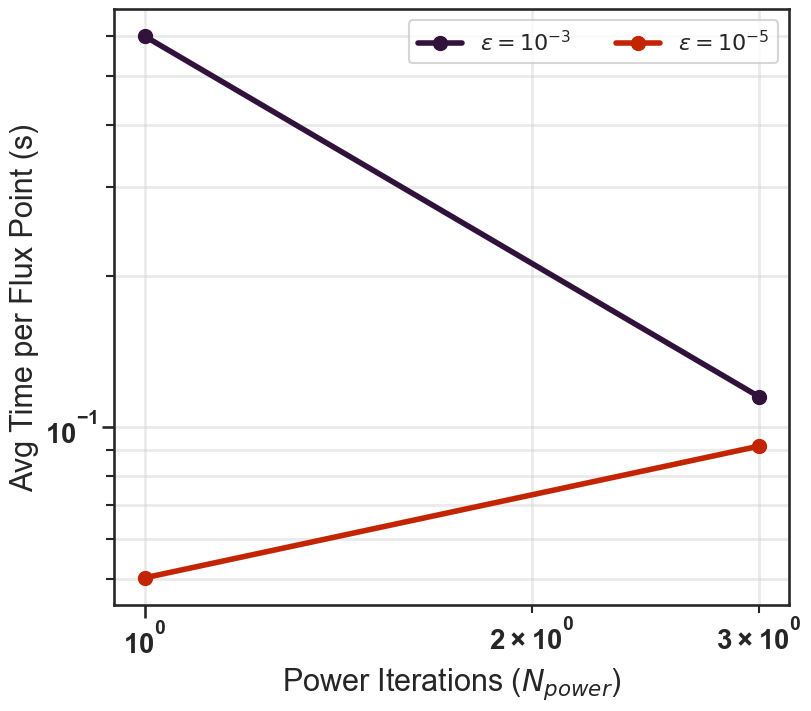

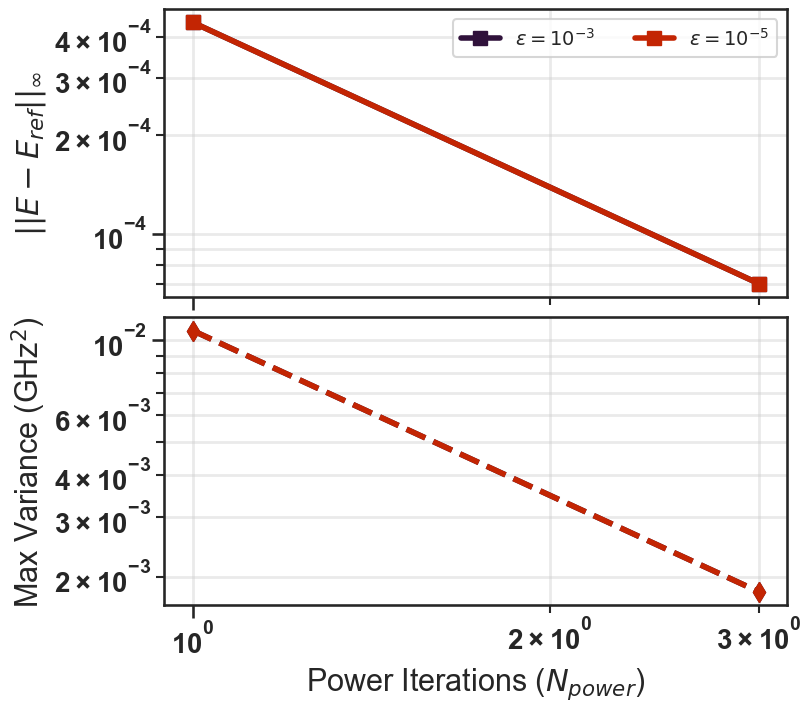

In [37]:
# --- CONFIGURATION PPT GLOBALE ---
base_size = 20
plt.rcParams.update({
    'font.size': base_size,
    'font.weight': 'bold',
    'axes.labelsize': base_size + 2,
    'xtick.labelsize': base_size,
    'ytick.labelsize': base_size,
    'legend.fontsize': 16,
    'lines.linewidth': 4,
    'lines.markersize': 10,
})

# Colormap pour les tolérances
colors = cm.turbo(np.linspace(0, 0.9, len(tol_values)))

# ==========================================
# FIG 1: PERFORMANCE (TIME)
# ==========================================
fig1, ax1 = plt.subplots(figsize=(8, 7), layout='constrained')

for t_idx, tol in enumerate(tol_values):
    ax1.loglog(n_power_values, res_time[t_idx, :], 
               marker='o', linestyle='-', color=colors[t_idx], 
               label=f'$\\epsilon = 10^{{{int(np.log10(tol))}}}$')

ax1.set_xlabel(r'Power Iterations ($N_{power}$)')
ax1.set_ylabel('Avg Time per Flux Point (s)')
# Pas de titre
ax1.grid(True, which="both", alpha=0.4, linewidth=2)
ax1.legend(loc='best', ncol=2) 

plt.show()

# ==========================================
# FIG 2: ACCURACY (ENERGY & VARIANCE) EMPILÉS
# ==========================================
fig_comb, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(8, 7), sharex=True, layout='constrained')

# --- HAUT : ENERGY ERROR ---
for t_idx, tol in enumerate(tol_values):
    ax_top.loglog(n_power_values, res_energy_err[t_idx, :], 
                  marker='s', linestyle='-', color=colors[t_idx], 
                  label=f'$\\epsilon = 10^{{{int(np.log10(tol))}}}$')

ax_top.set_ylabel(r'$||E - E_{ref}||_\infty$')
ax_top.grid(True, which="both", alpha=0.4, linewidth=2)
ax_top.legend(loc='best', fontsize=14, ncol=2)

# --- BAS : VARIANCE ---
for t_idx, tol in enumerate(tol_values):
    # Pas de légende en bas pour ne pas surcharger, on l'a déjà en haut
    ax_bot.loglog(n_power_values, res_variance[t_idx, :], 
                  marker='d', linestyle='--', color=colors[t_idx], 
                  label='_nolegend_')

ax_bot.set_xlabel(r'Power Iterations ($N_{power}$)')
ax_bot.set_ylabel(r'Max Variance (GHz$^2$)')
ax_bot.grid(True, which="both", alpha=0.4, linewidth=2)

plt.show()

### Benchmark reference vs shift invert one energy 

Hilbert space size

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- CONFIGURATION ---
base_dims = np.array([19, 32, 32, 5])
flux_prev = 1.595
flux_curr = 1.5951
divisors = [2.05, 1.75, 1.35, 1.12, 1.0,0.9]
divisors = [2.05, 1.9]

# Paramètres
dim_kept = 100
target_idx = dim_kept-1
shift_val = 5*1e-8
tol_val = 1e-12
n_pow = 4

# Stockage
results = {
    "hilbert_size": [], "time_ref": [], "time_si": [],
    "fidelity": [], "variance_si": [], "variance_ref": []
}

print(f"⚔️ SCALING TEST : DUEL COMPLET ⚔️")

for div in tqdm(divisors, desc="Simulations"):
    
    # 1. Dimensions & Opérateurs Dynamiques
    raw_dims = (base_dims / div).astype(int)
    curr_dims = np.where(raw_dims % 2 == 0, raw_dims + 1, raw_dims)
    curr_dims = np.maximum(curr_dims, 3)
    curr_dims_tuple = tuple(curr_dims)
    hilbert_size = np.prod(curr_dims)
    
    results["hilbert_size"].append(hilbert_size)

    # Construction des opérateurs pour CETTE dimension
    ops_curr = vkite.build_static_operators(curr_dims_tuple, **parameters)

    # Wrapper local
    def current_wrapper(phi, sigma):
        return get_shifted_kite_operator_real(
            phiext_val=phi, ops=ops_curr, dims=curr_dims_tuple, n_g=0.0, sigma=sigma
        )

    # 2. État "Guess" (Flux précédent)
    ev_prev, ek_prev = vkite.get_qr_esys_from_ops(ops_curr,
        dims=curr_dims_tuple, dim_kept=dim_kept, n_g=0.0, phiext=flux_prev,
    )
    v_guess = ek_prev[:, target_idx]
    E_guess = ev_prev[target_idx] 

    # 3. Référence (QR à flux_curr)
    t0 = time.time()
    ev_ref, ek_ref = vkite.get_qr_esys_from_ops(ops_curr,
        dims=curr_dims_tuple, dim_kept=dim_kept, n_g=0.0, phiext=flux_curr
    )
    results["time_ref"].append(time.time() - t0)
    
    v_ref = ek_ref[:, target_idx]/np.linalg.norm(ek_ref[:, target_idx])
    E_ref = ev_ref[target_idx]

    # 4. Shift-Invert (Tracking vers flux_curr)
    t0 = time.time()
    Es_si, Vs_si = get_branch_jax(
        current_wrapper, E_guess, v_guess, [flux_prev, flux_curr], 
        shift=shift_val, tol=tol_val, tol_exit=tol_val, N_power=n_pow
    )
    results["time_si"].append(time.time() - t0)
    
    v_si = np.array(Vs_si[-1]).reshape(-1, 1)
    v_si = v_si / np.linalg.norm(v_si)
    E_si = Es_si[-1]

    # 5. Métriques
    # A. Fidélité
    fid = np.abs(np.vdot(v_si.flatten(), v_ref.flatten()))**2
    results["fidelity"].append(fid)

    # B. Variance Intrinseque
    def calc_variance(vec, nrg):
        hv = vkite.apply_qr_hamitonian_to_vec(
            ops_curr, curr_dims_tuple, vec.reshape(-1, 1), n_g=0.0, phiext=flux_curr
        )
        resid = hv - nrg * vec.reshape(-1, 1)
        return np.linalg.norm(resid)**2

    results["variance_si"].append(calc_variance(v_si, E_si))
    results["variance_ref"].append(calc_variance(v_ref, E_ref))


# --- PLOT FINAL ---
# constrained_layout gère mieux l'espacement que tight_layout pour 3 panneaux
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12), sharex=True, constrained_layout=True)

# --- PANEL A: TEMPS ---
ax1.loglog(results["hilbert_size"], results["time_ref"], 's-', color='#555555', label='Reference (QR)')
ax1.loglog(results["hilbert_size"], results["time_si"], 'o-', color='#D62728', label='Shift-Invert (SI)')
ax1.set_ylabel("Execution Time (s)")
ax1.set_title(r"$\bf{(a)}$ Computational Scaling", loc='left')
ax1.legend()

# --- PANEL B: INFIDÉLITÉ (Correction ici) ---
# On trace 1 - Fidelité pour voir l'erreur en log scale
infidelity = 1.0 - np.array(results["fidelity"])
infidelity = np.maximum(infidelity, 1e-18) # Sécurité pour éviter log(0)

ax2.loglog(results["hilbert_size"], infidelity, 'd-', color='#2CA02C')
ax2.set_ylabel(r"Infidelity ($1 - F$)")
ax2.set_title(r"$\bf{(b)}$ Error vs Exact Solution", loc='left')
# PAS de ticklabel_format ici car on est en log !

# --- PANEL C: VARIANCE ---
ax3.loglog(results["hilbert_size"], results["variance_ref"], 's--', color='#555555', alpha=0.6, label='Ref Limit')
ax3.loglog(results["hilbert_size"], results["variance_si"], 'o-', color='#FF7F0E', label='SI Residual')
ax3.set_ylabel(r"Variance $||\hat{H}\psi - E\psi||^2$")
ax3.set_xlabel("Hilbert Space Dimension")
ax3.set_title(r"$\bf{(c)}$ Intrinsic Eigenstate Quality", loc='left')
ax3.legend()

plt.show()

⚔️ SCALING TEST : DUEL COMPLET ⚔️


Simulations: 100%|██████████| 2/2 [01:04<00:00, 32.05s/it]


Other parameters

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm

# --- CONFIGURATION (Soft Bench) ---
base_dims = np.array([19, 32, 32, 5])
divisors = [1] 
flux_prev = 1.595 

# PARAMÈTRES VARIABLES
flux_steps = [1e-2,1e-3,1e-4] 
dim_kept_values = [10,25,50,100,200] # Version soft pour test rapide
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Paramètres algo
tol_val = 1e-12
n_pow = 4 

# Stockage des résultats
# On sort variance_ref des steps car calculé une seule fois
results = {
    "dim_kept": dim_kept_values,
    "time_ref_baseline": [], 
    "variance_ref_baseline": [] 
}

for step in flux_steps:
    results[step] = {
        "time_si": [],
        "variance_si": [],
        "overlap_si": [],
        "overlap_ref": [] # Obligé de le garder par step (physique)
    }

print(f"⚔️ OPTIMIZED BENCHMARK ⚔️")

# --- 1. PRÉ-CALCUL MATRICE ---
div = 1.6
raw_dims = (base_dims // div).astype(int)
curr_dims = np.where(raw_dims % 2 == 0, raw_dims + 1, raw_dims)
curr_dims = np.maximum(curr_dims, 3)
curr_dims_tuple = tuple(curr_dims)
hilbert_size = np.prod(curr_dims)
curr_dims = base_dims
curr_dims_tuple = tuple(curr_dims)
hilbert_size = np.prod(curr_dims)

print(f"Hilbert Size: {hilbert_size}")
ops_curr = vkite.build_static_operators(curr_dims_tuple, **parameters)

# Fonction utilitaire variance
def get_variance(vec, nrg, phi_loc):
    hv = vkite.apply_qr_hamitonian_to_vec(
        ops_curr, curr_dims_tuple, vec.reshape(-1, 1), n_g=0.0, phiext=phi_loc
    )
    resid = hv - nrg * vec.reshape(-1, 1)
    return np.linalg.norm(resid)**2

# --- 2. BOUCLE PRINCIPALE ---
for k in tqdm(dim_kept_values, desc="Spectral Depth Loop"):
    
    target_idx = k - 1 

    # A. REFERENCE BASELINE (Flux Prev)
    # On s'en sert pour le Temps et la Variance de référence (indépendants du step)
    t0_ref = time.time()
    ev_prev, ek_prev = vkite.get_qr_esys_from_ops(ops_curr,
        dims=curr_dims_tuple, dim_kept=k, n_g=0.0, phiext=flux_prev,
    )
    results["time_ref_baseline"].append(time.time() - t0_ref)
    
    v_prev_ref = ek_prev[:, target_idx] 
    E_prev_ref = ev_prev[target_idx]
    
    # Calcul de la variance de référence (une seule fois)
    # Elle est intrinsèque à la méthode QR, donc constante.
    var_ref = get_variance(v_prev_ref, E_prev_ref, flux_prev)
    results["variance_ref_baseline"].append(var_ref)

    # B. BOUCLE SUR LES STEPS
    for step in flux_steps:
        flux_curr = flux_prev + step
        
        # --- 1. REFERENCE CIBLE (Juste pour l'Overlap) ---
        # Note : On doit quand même diagonaliser à flux_curr pour savoir 
        # où est le "vrai" vecteur et calculer l'overlap réel.
        ev_new_ref, ek_new_ref = vkite.get_qr_esys_from_ops(ops_curr,
            dims=curr_dims_tuple, dim_kept=k, n_g=0.0, phiext=flux_curr,
        )
        v_new_ref = ek_new_ref[:, target_idx] / np.linalg.norm(ek_new_ref[:, target_idx])
        
        # Overlap Reference (La vérité terrain change avec la distance step)
        ov_ref = np.abs(np.vdot(v_prev_ref.flatten(), v_new_ref.flatten()))
        results[step]["overlap_ref"].append(ov_ref)

        # --- 2. SHIFT-INVERT (Tracking) ---
        def step_wrapper(phi, sigma):
            return get_shifted_kite_operator_real(
                phiext_val=phi, ops=ops_curr, dims=curr_dims_tuple, n_g=0.0, sigma=sigma
            )

        t0_si = time.time()
        Es_si, Vs_si = get_branch_jax(
            step_wrapper, E_prev_ref, v_prev_ref, [flux_prev, flux_curr], 
            shift=5e-8, 
            tol=tol_val, tol_exit=tol_val, N_power=n_pow
        )
        results[step]["time_si"].append(time.time() - t0_si)
        
        v_si = np.array(Vs_si[-1]).reshape(-1, 1)
        v_si = v_si / np.linalg.norm(v_si)
        E_si = Es_si[-1]
        
        # Metrics SI
        var_si = get_variance(v_si, E_si, flux_curr)
        ov_si = np.abs(np.vdot(v_prev_ref.flatten(), v_si.flatten())) 
        
        results[step]["variance_si"].append(var_si)
        results[step]["overlap_si"].append(ov_si)




⚔️ OPTIMIZED BENCHMARK ⚔️
Hilbert Size: 97280


Spectral Depth Loop:   0%|          | 0/5 [00:00<?, ?it/s]

Spectral Depth Loop: 100%|██████████| 5/5 [1:56:41<00:00, 1400.22s/it]


In [28]:
import matplotlib.pyplot as plt

# --- CONFIGURATION PPT (SIDE-BY-SIDE) ---
base_size = 20
plt.rcParams.update({
    'font.size': base_size,
    'font.weight': 'bold',
    'axes.labelsize': base_size + 2,
    # 'axes.titlesize': base_size + 4, # Plus besoin de titre
    'xtick.labelsize': base_size,
    'ytick.labelsize': base_size,
    'legend.fontsize': 16,
    'lines.linewidth': 4,
    'lines.markersize': 10,
})

# ==========================================
# GAUCHE : COMPUTATIONAL COST
# ==========================================
fig1, ax1 = plt.subplots(figsize=(8, 7), layout='constrained')

# Trace Lanczos (Reference)
ax1.loglog(results["dim_kept"], results["time_ref_baseline"], 'k--', label='Lanczos', linewidth=4, alpha=0.7)

# Trace SI
for i, step in enumerate(flux_steps):
    ax1.loglog(results["dim_kept"], results[step]["time_si"], 'o-', color=colors[i], label=f'SI step={step:.0e}')

ax1.set_xlabel("Target Eigenstate Index")
ax1.set_ylabel("Computation Time (s)")
# PAS DE TITRE ICI
ax1.grid(True, which="both", alpha=0.4, linewidth=2)
ax1.legend(loc='best')

plt.show()

# ==========================================
# DROITE : QUALITÉ & CONSISTENCY (EMPILÉS)
# ==========================================
fig_comb, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(8, 7), sharex=True, layout='constrained')

# --- HAUT : VARIANCE ---
ax_top.loglog(results["dim_kept"], results["variance_ref_baseline"], 
           color='black', linestyle='--', linewidth=4, alpha=0.8, 
           label='Lanczos')

for i, step in enumerate(flux_steps):
    ax_top.loglog(results["dim_kept"], results[step]["variance_si"], 
               marker='s', linestyle='-', color=colors[i], 
               label=f'SI Step={step:.0e}')

ax_top.set_ylabel(r"Variance (GHz$^2$)")
# PAS DE TITRE ICI
ax_top.grid(True, which="both", alpha=0.4, linewidth=2)
ax_top.legend(loc='best', fontsize=14, ncol=2) 


# --- BAS : OVERLAP ---
for i, step in enumerate(flux_steps):
    c = colors[i]
    # Lanczos (Pas de légende)
    ax_bot.semilogx(results["dim_kept"], results[step]["overlap_ref"], 
                 linestyle='--', color=c, linewidth=3, alpha=0.6,
                 label='_nolegend_')
    
    # Shift Invert (Légende)
    ax_bot.semilogx(results["dim_kept"], results[step]["overlap_si"], 
                 linestyle='-', marker='o', color=c, alpha=0.9,
                 label=f'SI step={step:.0e}')

ax_bot.set_ylabel(r"Overlap")
ax_bot.set_xlabel("Target Eigenstate Index")
ax_bot.grid(True, which="both", alpha=0.4, linewidth=2)

# Zoom intelligent
all_ov = []
for s in flux_steps: all_ov.extend(results[s]["overlap_ref"])
if len(all_ov) > 0:
    ov_min = min(all_ov)
    margin = (1 - ov_min) * 0.2 if ov_min < 0.99 else 0.002
    ax_bot.set_ylim(bottom=ov_min - margin, top=1.05)

# Légende et Annotation
ax_bot.legend(loc='lower left', fontsize=14, ncol=2)

ax_bot.text(0.98, 0.05, "---  Solid: Shift-Invert\n- - - Dashed: Lanczos", 
         transform=ax_bot.transAxes, 
         ha='right', va='bottom', 
         fontsize=14, fontweight='bold',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.3'))

plt.show()

### Benchmark solver variance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Définition de la plage de test
flux_test_vals = np.linspace(1.6, 1.7, 5)
variances_ref = []

# 2. Reconstruction impérative des opérateurs (garantit la cohérence H vs paramètres)
local_ops = vkite.build_static_operators(dims, **parameters)

for phi in flux_test_vals:
    # A. Appel du solveur de référence
    ev, ek, _ = vkite.get_qr_esys_with_jac(
        dims=dims, dim_kept=8, n_g=0.0, phiext=float(phi),
        **parameters, output_jac_params=()
    )
    
    # B. Extraction et Normalisation du vecteur (Branche 7 = Haut)
    v = ek[:, 7].reshape(-1, 1)
    v = v / np.linalg.norm(v)
    
    # C. Calcul Variance Intrinsèque
    hv = vkite.apply_qr_hamitonian_to_vec(local_ops, dims, v, n_g=0.0, phiext=float(phi))
    
    # Energie locale <v|H|v> (Scalaire pur)
    e_local = np.vdot(v, hv).real 
    
    # Résidu ||Hv - Ev||^2
    resid = hv - e_local * v
    variances_ref.append(np.linalg.norm(resid)**2)

# 3. Affichage
plt.figure(figsize=(8, 5))
plt.semilogy(flux_test_vals, variances_ref, 'x--', color='black', label='Ref Intrinsic Variance')
plt.xlabel('Flux')
plt.ylabel('Variance')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.show()

print("Variances obtenues :", variances_ref)

Variances obtenues : [np.float64(1.3446088731763543e-26), np.float64(1.370353804365385e-26), np.float64(1.7272840685509977e-26), np.float64(5.092343135754629e-27), np.float64(8.313907802402093e-27)]


In [166]:
import numpy as np


parameters = vkite.ParamType(
    ECs_GHz=0.072472,
    EL_GHz=1.269,
    ECJ_GHz=4.9895,
    EJ_GHz=17.501,
    eps=0.05702,
    ECc_GHz=0.003989,
    f_r_GHz=4.337,
)


dims = vkite.DEFAULT_DIMS
dims = tuple((np.array(dims) // 1.6).astype(int))
print(f'dimension Hilbert space = {dims}')

ops = vkite.build_static_operators(dims = dims, **parameters)

def my_wrapper(phi, sigma):
    return get_shifted_kite_operator_real(phiext_val=phi, ops=ops, dims=dims, n_g=0.0, sigma=sigma)

flux_start = 1.645
flux_target = 1.650
target_idx = 7 

# 1. État initial (Référence au point précédent)
ev_prev, ek_prev, _ = vkite.get_qr_esys_with_jac(
    dims=dims, dim_kept=8, n_g=0.0, phiext=flux_start,
    **parameters, output_jac_params=tuple()
)
E_init = ev_prev[target_idx]
v_init = ek_prev[:, target_idx]

# 2. Tracking Shift-Invert vers le point cible
Es, Vs = get_branch_jax(
    my_wrapper, E_init, v_init, [flux_start, flux_target],
    shift=1e-6, tol=1e-11, tol_exit=1e-14, N_power=3
)



v_final = np.array(Vs[1]).reshape(-1, 1)
v_final = v_final / np.linalg.norm(v_final)

hv = vkite.apply_qr_hamitonian_to_vec(
    ops, dims, v_final, n_g=0.0, phiext=flux_target
)

resid = hv - Es[1] * v_final
variance = np.linalg.norm(resid)**2

print(f"Variance Shift-Invert à {flux_target} : {variance:.4e}")

dimension Hilbert space = (np.int64(11), np.int64(19), np.int64(19), np.int64(3))


100%|██████████| 1/1 [00:02<00:00,  2.73s/it]

Variance Shift-Invert à 1.65 : 7.7728e-17
